In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import h5py
import random

with h5py.File("gdrive/My Drive/FDL project/dataset/background_for_training.h5", 'r') as file:
    data = file['Particles'][:]
    n_dataset_elements = data.shape[0]

print(data.shape)

(13451915, 19, 4)


## Standard scaler
$$
z_i = \frac{x_i - \bar{x}}{\delta x}
$$

where $\bar{x}$ is the mean and $\delta x$ is the Standard Deviation of the dataset

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

def scaler(data):
    data_scaled = np.zeros_like(data)

    for i in range(data.shape[2]):
        scaler = StandardScaler()
        data_feat = data[:, :, i].reshape(-1, 1)
        scaler.fit(data_feat)

        data_scaled[:, :, i] = scaler.transform(data_feat).reshape(data.shape[0], 19)

    return data_scaled

data_scaled = scaler(data)

In [ ]:
from sklearn.model_selection import train_test_split

test_size=0.1
val_size=0.2

train_val_data, test_data = train_test_split(data_scaled, test_size=test_size, random_state=42)

val_relative_size = val_size / (1 - test_size)
train_data, val_data = train_test_split(train_val_data, test_size=val_relative_size, random_state=42)

print(f"Train shape: {train_data.shape}")
print(f"Validation shape: {val_data.shape}")
print(f"Test shape: {test_data.shape}")

Train shape: (9416340, 19, 4)
Validation shape: (2690383, 19, 4)
Test shape: (1345192, 19, 4)


 ## Network

In [ ]:
import keras
import tensorflow as tf

regularizer_rate = 1e-4
dropout_rate = 0.01

inputs = keras.Input(shape=(19, 4, 1))

# ------------------ Encoder ------------------
x = keras.layers.Conv2D(16, (3, 1), padding="same", kernel_regularizer=keras.regularizers.l2(regularizer_rate))(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Dropout(dropout_rate)(x)

x = keras.layers.Conv2D(32, (3, 1), padding="same", kernel_regularizer=keras.regularizers.l2(regularizer_rate))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Dropout(dropout_rate)(x)

x = keras.layers.MaxPooling2D(pool_size=(2, 1), padding="same")(x)

x = keras.layers.Conv2D(64, (3, 1), padding="same", kernel_regularizer=keras.regularizers.l2(regularizer_rate))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Dropout(dropout_rate)(x)

x = keras.layers.MaxPooling2D(pool_size=(2, 1), padding="same")(x)

# ------------------ Bottleneck ------------------
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128, kernel_regularizer=keras.regularizers.l2(regularizer_rate))(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Dense(5 * 4 * 64, kernel_regularizer=keras.regularizers.l2(regularizer_rate))(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Reshape((5, 4, 64))(x)

# ------------------ Decoder ------------------
x = keras.layers.Conv2DTranspose(32, (3, 1), strides=(2, 1), padding="same", kernel_regularizer=keras.regularizers.l2(regularizer_rate))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)

x = keras.layers.Conv2DTranspose(16, (3, 1), strides=(2, 1), padding="same", kernel_regularizer=keras.regularizers.l2(regularizer_rate))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)

x = keras.layers.Cropping2D(cropping=((1, 0), (0, 0)))(x)

x = keras.layers.Conv2D(1, (3, 1), padding="same")(x)

outputs = x

net = keras.Model(inputs, outputs)
net.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 19, 4, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 19, 4, 16)      │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 19, 4, 16)      │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 19, 4, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 19, 4, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 19, 4, 32)      │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 19, 4, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 19, 4, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 4, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 10, 4, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 4, 64)      │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 4, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 10, 4, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 4, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1280)           │       165,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 5, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 10, 4, 32)      │         6,176 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10, 4, 32)      │           12

 Total params: 345,345 (1.32 MB)

 Trainable params: 345,025 (1.32 MB)

 Non-trainable params: 320 (1.25 KB)

## Training

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


# Compile
net.compile(
    loss=keras.losses.mean_squared_error,
    optimizer=keras.optimizers.Adam(learning_rate=1e-3)
 )

# Training
history = net.fit(
    train_data,
    train_data,
    validation_data=(val_data, val_data),
    epochs=100,
    batch_size=512,
    shuffle=True,
    callbacks=[reduce_lr, early_stopping]
)

net.save_weights("gdrive/My Drive/FDL project/CNN.weights.h5")

Epoch 1/100
18392/18392 ━━━━━━━━━━━━━━━━━━━━ 128s 6ms/step - loss: 0.0331 - val_loss: 0.0069 - learning_rate: 0.0010
Epoch 2/100
18392/18392 ━━━━━━━━━━━━━━━━━━━━ 108s 6ms/step - loss: 0.0062 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 3/100
18392/18392 ━━━━━━━━━━━━━━━━━━━━ 107s 6ms/step - loss: 0.0047 - val_loss: 0.0055 - learning_rate: 0.0010
Epoch 4/100
18392/18392 ━━━━━━━━━━━━━━━━━━━━ 108s 6ms/step - loss: 0.0048 - val_loss: 0.0078 - learning_rate: 0.0010
Epoch 5/100
18392/18392 ━━━━━━━━━━━━━━━━━━━━ 107s 6ms/step - loss: 0.0049 - val_loss: 0.0038 - learning_rate: 0.0010
Epoch 6/100
18392/18392 ━━━━━━━━━━━━━━━━━━━━ 107s 6ms/step - loss: 0.0044 - val_loss: 0.0043 - learning_rate: 0.0010
Epoch 7/100
18392/18392 ━━━━━━━━━━━━━━━━━━━━ 107s 6ms/step - loss: 0.0044 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 8/100
18392/18392 ━━━━━━━━━━━━━━━━━━━━ 108s 6ms/step - loss: 0.0046 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 9/100
18392/18392 ━━━━━━━━━━━━━━━━━━━━ 107s 6ms/step - los

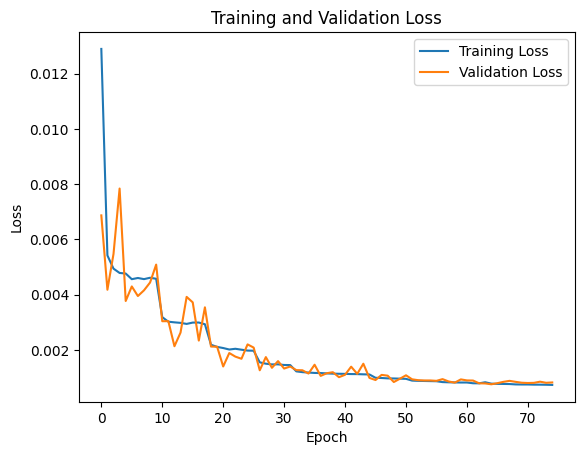

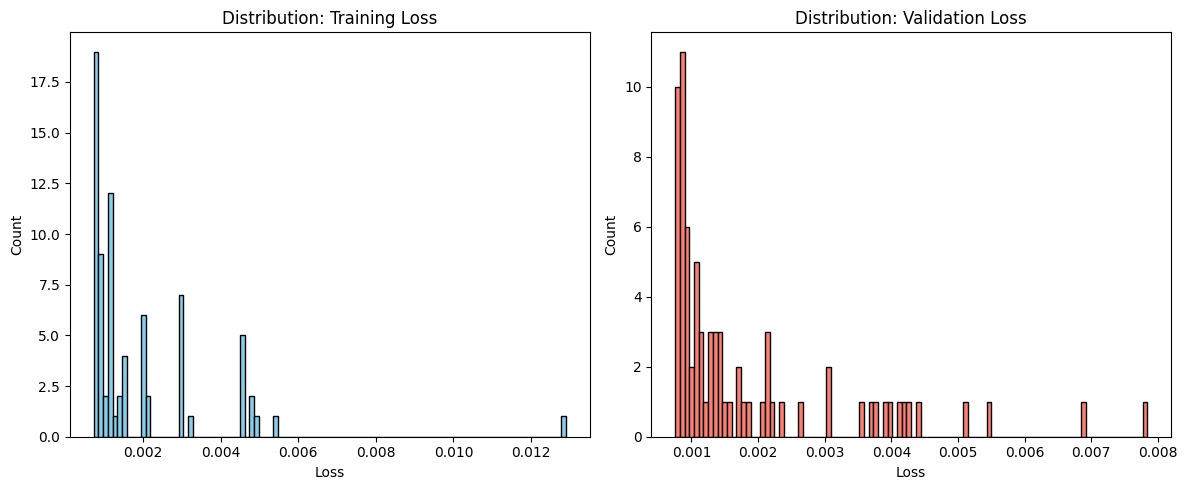

In [ ]:
import matplotlib.pyplot as plt

def visualize_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


def visualize_loss_pdf(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].hist(loss, bins=100, color='skyblue', edgecolor='black')
    axes[0].set_title('Distribution: Training Loss')
    axes[0].set_xlabel('Loss')
    axes[0].set_ylabel('Count')

    axes[1].hist(val_loss, bins=100, color='salmon', edgecolor='black')
    axes[1].set_title('Distribution: Validation Loss')
    axes[1].set_xlabel('Loss')
    axes[1].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

visualize_loss(history)
visualize_loss_pdf(history)

# Data Analysis

## Function to visualize the results

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import roc_curve, auc


def loss_eventXevent(y_true, y_rec, c_p_t=1, c_eta=1, c_phi=1, zero_pt = -3.65475940e-01, zero_eta = 2.74188967e-04, zero_phi = -7.03800890e-05, step=0.001):
    """
    Calculates and visualizes the loss for each particle type (MET, electron, muon, jet) by plotting histograms of their losses.

    param: y_true, numpy array of shape (n_samples, n_properties) for true data
    param: y_rec, numpy array of shape (n_samples, n_properties) for predicted data
    """
    MET_loss = []
    e_loss = []
    mu_loss = []
    jet_loss = []

    total_loss = []
    N = y_true.shape[0]

    for true, pred in zip(y_true, y_rec):
        #MET
        for true_particle, pred_particle in zip(true[0:1], pred[0:1]):
            # print(true_particle.shape, pred_particle.shape)
            if true_particle[0] > zero_pt - step and true_particle[0] < zero_pt + step and true_particle[1] > zero_eta - step and true_particle[1] < zero_eta + step and true_particle[2] > zero_phi - step and true_particle[2] < zero_phi + step:
                continue
            else:
                p_t_loss = np.abs(true_particle[0] - pred_particle[0])
                eta_loss = (true_particle[1] - pred_particle[1])**2
                phi_loss = (true_particle[2] - pred_particle[2])**2
                MET_loss.append((c_p_t * p_t_loss + c_eta * eta_loss + c_phi * phi_loss)/N)
                total_loss.append((c_p_t * p_t_loss + c_eta * eta_loss + c_phi * phi_loss)/N)
        # e
        for true_particle, pred_particle in zip(true[1:5], pred[1:5]):
            # print(true_particle.shape, pred_particle.shape)
            if true_particle[0] > zero_pt - step and true_particle[0] < zero_pt + step and true_particle[1] > zero_eta - step and true_particle[1] < zero_eta + step and true_particle[2] > zero_phi - step and true_particle[2] < zero_phi + step:
                continue
            else:
                p_t_loss = np.abs(true_particle[0] - pred_particle[0])
                eta_loss = (true_particle[1] - pred_particle[1])**2
                phi_loss = (true_particle[2] - pred_particle[2])**2
                e_loss.append((c_p_t * p_t_loss + c_eta * eta_loss + c_phi * phi_loss)/N)
                total_loss.append((c_p_t * p_t_loss + c_eta * eta_loss + c_phi * phi_loss)/N)

        # mu
        for true_particle, pred_particle in zip(true[5:9], pred[5:9]):
            # print(true_particle.shape, pred_particle.shape)
            if true_particle[0] > zero_pt - step and true_particle[0] < zero_pt + step and true_particle[1] > zero_eta - step and true_particle[1] < zero_eta + step and true_particle[2] > zero_phi - step and true_particle[2] < zero_phi + step:
                continue
            else:
                p_t_loss = np.abs(true_particle[0] - pred_particle[0])
                eta_loss = (true_particle[1] - pred_particle[1])**2
                phi_loss = (true_particle[2] - pred_particle[2])**2
                mu_loss.append((c_p_t * p_t_loss + c_eta * eta_loss + c_phi * phi_loss)/N)
                total_loss.append((c_p_t * p_t_loss + c_eta * eta_loss + c_phi * phi_loss)/N)

        # jet
        for true_particle, pred_particle in zip(true[9:], pred[9:]):
            # print(true_particle.shape, pred_particle.shape)
            if true_particle[0] > zero_pt - step and true_particle[0] < zero_pt + step and true_particle[1] > zero_eta - step and true_particle[1] < zero_eta + step and true_particle[2] > zero_phi - step and true_particle[2] < zero_phi + step:
                continue
            else:
                p_t_loss = np.abs(true_particle[0] - pred_particle[0])
                eta_loss = (true_particle[1] - pred_particle[1])**2
                phi_loss = (true_particle[2] - pred_particle[2])**2
                jet_loss.append((c_p_t * p_t_loss + c_eta * eta_loss + c_phi * phi_loss)/N)
                total_loss.append((c_p_t * p_t_loss + c_eta * eta_loss + c_phi * phi_loss)/N)

    return MET_loss, e_loss, mu_loss, jet_loss, total_loss


def propertis_division(data):
    """
    Divides the input data into properties for MET, electrons, muons, and jets.
    """
    MET_p_t, MET_eta, MET_phi = data[:, 0, 0], data[:, 0, 1], data[:, 0, 2]
    e_p_t, e_eta, e_phi = data[:, 1:5, 0], data[:, 1:5, 1], data[:, 1:5, 2]
    mu_p_t, mu_eta, mu_phi = data[:, 5:9, 0], data[:, 5:9, 1], data[:, 5:9, 2]
    jet_p_t, jet_eta, jet_phi = data[:, 9:, 0], data[:, 9:, 1], data[:, 9:, 2]

    return (MET_p_t, MET_eta, MET_phi, e_p_t, e_eta, e_phi, mu_p_t, mu_eta, mu_phi, jet_p_t, jet_eta, jet_phi)


def visualize_results(y_true, y_rec):
    """
    Visualizes the results by plotting the true and reconstructed properties of particles.

    param: y_true, numpy array of shape (n_samples, n_particles, n_properties) for true data
    param: y_rec, numpy array of shape (n_samples, n_particles, n_properties) for reconstructed data
    """
    MET_p_t_true, MET_eta_true, MET_phi_true, e_p_t_true, e_eta_true, e_phi_true, mu_p_t_true, mu_eta_true, mu_phi_true, jet_p_t_true, jet_eta_true, jet_phi_true = propertis_division(y_true)
    MET_p_t_rec, MET_eta_rec, MET_phi_rec, e_p_t_rec, e_eta_rec, e_phi_rec, mu_p_t_rec, mu_eta_rec, mu_phi_rec, jet_p_t_rec, jet_eta_rec, jet_phi_rec = propertis_division(y_rec)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].scatter(jet_p_t_true, jet_p_t_rec, color="red", label=r"$jet$")
    ax[0].scatter(mu_p_t_true, mu_p_t_rec, color="purple", label=r"$\mu$")
    ax[0].scatter(e_p_t_true, e_p_t_rec, color="green", label=r"$e$")
    ax[0].scatter(MET_p_t_true, MET_p_t_rec, color="blue", label=r"$\nu$")
    ax[0].set_xlabel('Original data')
    ax[0].set_ylabel('Reconstructed data')
    ax[0].set_title(r'$p_T$')
    ax[0].legend(loc="lower right")
    ax[0].grid(True)

    ax[1].scatter(jet_eta_true, jet_eta_rec, color="red", label=r"$jet$")
    ax[1].scatter(mu_eta_true, mu_eta_rec, color="purple", label=r"$\mu$")
    ax[1].scatter(e_eta_true, e_eta_rec, color="green", label=r"$e$")
    ax[1].scatter(MET_eta_true, MET_eta_rec, color="blue", label=r"$\nu$")
    ax[1].set_xlabel('Original data')
    ax[1].set_ylabel('Reconstructed data')
    ax[1].set_title(r'$\eta$')
    ax[1].legend(loc="lower right")
    ax[1].grid(True)

    ax[2].scatter(jet_phi_true, jet_phi_rec, color="red", label=r"$jet$")
    ax[2].scatter(mu_phi_true, mu_phi_rec, color="purple", label=r"$\mu$")
    ax[2].scatter(e_phi_true, e_phi_rec, color="green", label=r"$e$")
    ax[2].scatter(MET_phi_true, MET_phi_rec, color="blue", label=r"$\nu$")
    ax[2].set_xlabel('Original data')
    ax[2].set_ylabel('Reconstructed data')
    ax[2].set_title(r'$\phi$')
    ax[2].legend(loc="lower right")
    ax[2].grid(True)


def residues_analysis(y_true, y_rec, n_bin=200):
    """
    Visualizes the distribution of residues for each property.

    param: y_true, numpy array of shape (n_samples, n_properties) for true data
    param: y_rec, numpy array of shape (n_samples, n_properties) for reconstructed data
    """
    MET_p_t_true, MET_eta_true, MET_phi_true, e_p_t_true, e_eta_true, e_phi_true, mu_p_t_true, mu_eta_true, mu_phi_true, jet_p_t_true, jet_eta_true, jet_phi_true = propertis_division(y_true)
    MET_p_t_rec, MET_eta_rec, MET_phi_rec, e_p_t_rec, e_eta_rec, e_phi_rec, mu_p_t_rec, mu_eta_rec, mu_phi_rec, jet_p_t_rec, jet_eta_rec, jet_phi_rec = propertis_division(y_rec)

    MET_p_t_res = MET_p_t_true - MET_p_t_rec
    MET_eta_res = MET_eta_true - MET_eta_rec
    MET_phi_res = MET_phi_true - MET_phi_rec

    e_p_t_res = e_p_t_true - e_p_t_rec
    e_eta_res = e_eta_true - e_eta_rec
    e_phi_res = e_phi_true - e_phi_rec

    mu_p_t_res = mu_p_t_true - mu_p_t_rec
    mu_eta_res = mu_eta_true - mu_eta_rec
    mu_phi_res = mu_phi_true - mu_phi_rec

    jet_p_t_res = jet_p_t_true - jet_p_t_rec
    jet_eta_res = jet_eta_true - jet_eta_rec
    jet_phi_res = jet_phi_true - jet_phi_rec

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].hist([jet_p_t_res.flatten(), mu_p_t_res.flatten(), e_p_t_res.flatten(), MET_p_t_res], bins=n_bin, color=["red", "purple", "green", "blue"], histtype="step", linewidth=2, label=[r"$jet$", r"$\mu$", r"$e$", r"$\nu$"])
    ax[0].set_xlabel(r'$p_T^{true} - p_T^{predict}$')
    ax[0].set_ylabel('Count')
    ax[0].set_yscale('log')
    ax[0].set_title(r'$p_T$')
    ax[0].legend(loc="upper right")
    ax[0].grid(True)

    ax[1].hist([jet_eta_res.flatten(), mu_eta_res.flatten(), e_eta_res.flatten(), MET_eta_res], bins=n_bin, color=["red", "purple", "green", "blue"], histtype="step", linewidth=2, label=[r"$jet$", r"$\mu$", r"$e$", r"$\nu$"])
    ax[1].set_xlabel(r'$\eta^{true} - \eta^{predict}$')
    ax[1].set_ylabel('Count')
    ax[1].set_yscale('log')
    ax[1].set_title(r'$\eta$')
    ax[1].legend(loc="upper right")
    ax[1].grid(True)

    ax[2].hist([jet_phi_res.flatten(), mu_phi_res.flatten(), e_phi_res.flatten(), MET_phi_res], bins=n_bin, color=["red", "purple", "green", "blue"], histtype="step", linewidth=2, label=[r"$jet$", r"$\mu$", r"$e$", r"$\nu$"])
    ax[2].set_xlabel(r'$\phi^{true} - \phi^{predict}$')
    ax[2].set_ylabel('Count')
    ax[2].set_yscale('log')
    ax[2].set_title(r'$\phi$')
    ax[2].legend(loc="upper right")
    ax[2].grid(True)

    plt.tight_layout()
    plt.show()


def visualize_loss_eventXevent(total_loss, MET_loss=None, e_loss=None, mu_loss=None, jet_loss=None, n_bin=200):
    """
    Visualizes the distribution of loss for each particle type (MET, electron, muon, jet) by plotting histograms of their losses.

    param: y_true, numpy array of shape (n_samples, n_properties) for true data
    param: y_rec, numpy array of shape (n_samples, n_properties) for predicted
    param: n_bin, number of bins for the histograms
    """
    if MET_loss is None and e_loss is None and mu_loss is None and jet_loss is None:
        plt.figure(figsize=(7,5))
        plt.hist(total_loss, bins=n_bin, color="blue")
        plt.xlabel(r'Loss')
        plt.ylabel('Count')
        plt.yscale('log')
        plt.xscale('log')
        plt.title(r'Total loss')

    else:
        fig, ax = plt.subplots(1, 2, figsize=(14, 5))
        if jet_loss is not None:
            ax[0].hist(jet_loss, bins=n_bin, color="red", histtype="step", linewidth=2, label=r"$jet$")
        if mu_loss is not None:
            ax[0].hist(mu_loss, bins=n_bin, color="purple", histtype="step", linewidth=2, label=r"$\mu$")
        if e_loss is not None:
            ax[0].hist(e_loss, bins=n_bin, color="green", histtype="step", linewidth=2, label=r"$e$")
        if MET_loss is not None:
            ax[0].hist(MET_loss, bins=n_bin, color="blue", histtype="step", linewidth=2, label=r"$\nu$")
        ax[0].set_xlabel(r'Loss')
        ax[0].set_ylabel('Count')
        ax[0].set_yscale('log')
        ax[0].set_xscale('log')
        ax[0].set_title(r'Loss')
        ax[0].legend(loc="upper right")
        ax[0].grid(True)

        ax[1].hist(total_loss, bins=n_bin, color="blue")
        ax[1].set_xlabel(r'Loss')
        ax[1].set_ylabel('Count')
        ax[1].set_yscale('log')
        ax[1].set_xscale('log')
        ax[1].set_title(r'Total loss')
        ax[1].grid(True)

    plt.tight_layout()
    plt.show()


def loss_eventXevent_comparison(background_loss, newphysics_loss: list, newphysics_names: list, n_bin=200):
    """
    Visualizes the distribution of loss for each particle type (MET, electron, muon, jet) by plotting histograms of their losses.

    param: y_true_background, numpy array of shape (n_samples, n_properties) for true data
    param: y_rec_background, numpy array of shape (n_samples, n_properties) for predicted
    param: y_true_newphysics, list of numpy arrays of shape (n_samples, n_properties) for true data
    param: y_rec_newphysics, list of numpy arrays of shape (n_samples, n_properties) for predicted
    param: newphysics_names, list of strings for the names of the newphysics datasets
    param: n_bin, number of bins for the histograms
    """
    plt.figure(figsize=(10,5))
    for i in range(len(newphysics_loss)):
        plt.hist(newphysics_loss[i], bins=n_bin, histtype="step", linewidth=2, label=newphysics_names[i])
    plt.hist(background_loss, bins=int(n_bin/4), histtype="step", linewidth=2, label="background")
    plt.xlabel(r'Loss')
    plt.ylabel('Count')
    plt.yscale('log')
    # plt.xscale('log')
    plt.title(r'Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


def ROC_curves(loss_background, newphysics_loss: list, newphysics_names: list):
    loss_background = np.array(loss_background)
    for i in range(len(newphysics_loss)):
        newphysics_loss[i] = np.array(newphysics_loss[i])

    bsm_losses = {new_ph: loss for new_ph, loss in zip(newphysics_names, newphysics_loss)}

    # Plot ROC curves
    plt.figure(figsize=(8, 6))

    for label, bsm_loss in bsm_losses.items():
        # Combine SM and BSM loss arrays
        y_true = np.concatenate([
            np.zeros(len(loss_background)),    # 0 for SM
            np.ones(len(bsm_loss))  # 1 for BSM
        ])
        y_scores = np.concatenate([loss_background, bsm_loss])

        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)

        # Plot
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.3f})')

    # Plot random guess line
    plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for BSM Detection (Autoencoder)')
    plt.legend(loc='lower right', fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Network weights loading


In [ ]:
net.load_weights("gdrive/My Drive/FDL project/weights/CNN.weights.h5")

## True  data vs Reconstructed data
### Scatter plot for each property


15625/15625 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step


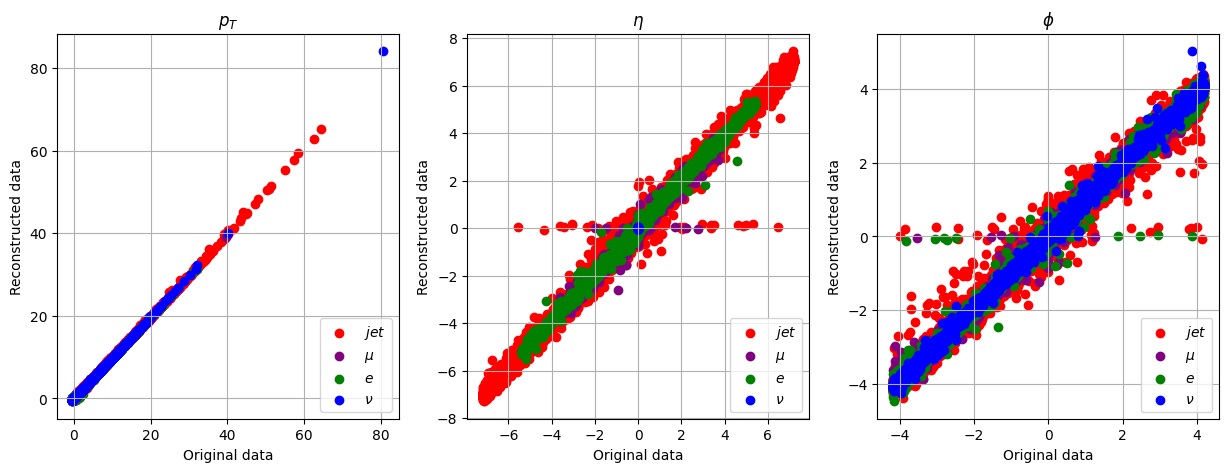

In [ ]:
# train_rec = net.predict(train_data)
test_rec = net.predict(test_data)

# visualize_results(train_data, train_rec)
visualize_results(test_data, test_rec)

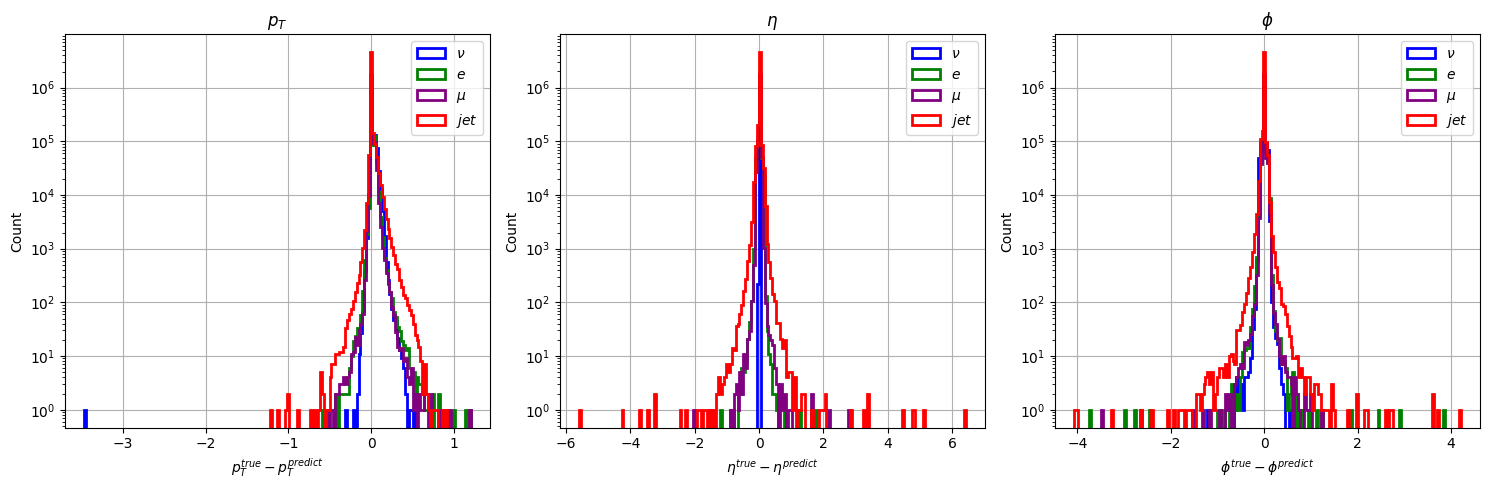

In [ ]:
residues_analysis(test_data, test_rec[:, :, :, 0])

### Loss computation for batchsize = 1
$$
\mathcal{L}_j = \frac{1}{N_{event}}\bigg[|p_{Tj}^{true} - p_{Tj}^{predict}| + (\eta^{true}_j - \eta^{predict}_j)^2 + (\phi^{true}_j - \phi^{predict}_j)^2\bigg]
$$

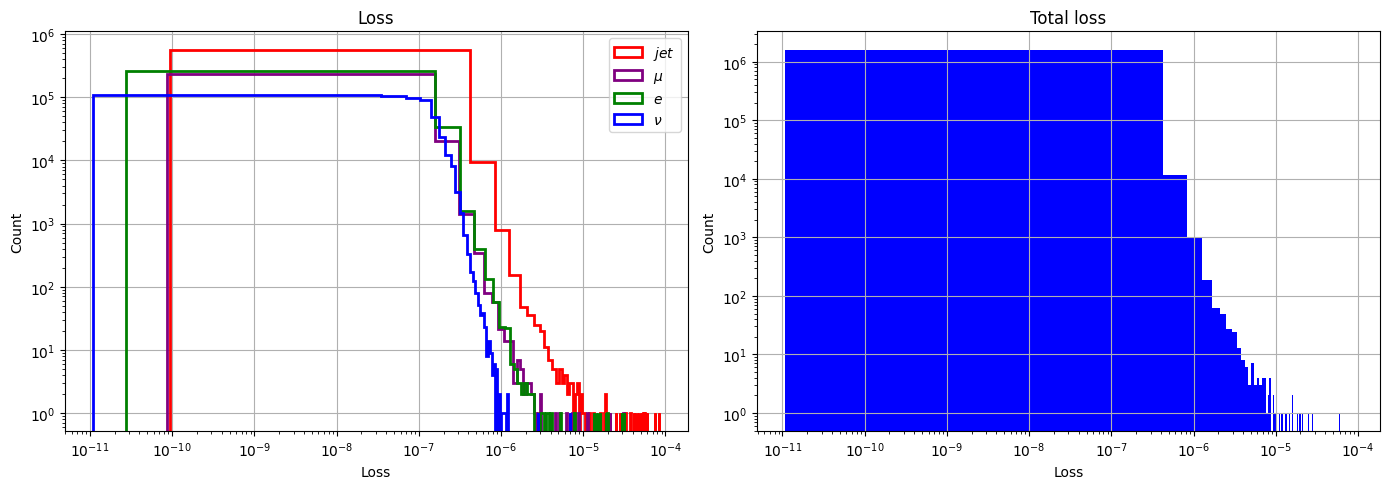

In [ ]:
MET_loss, e_loss, mu_loss, jet_loss, loss = loss_eventXevent(test_data, test_rec[:, :, :, 0])
visualize_loss_eventXevent(loss, MET_loss, e_loss, mu_loss, jet_loss)

## Study of 0

In [ ]:
def zero_idex(y_true, y_rec, threshold=0.01):
    zero_p_t_index = []
    zero_eta_index = []
    zero_phi_index = []
    zero_index = []

    zero_pt = -3.65475940e-01
    zero_eta = 2.74188967e-04
    zero_phi = 7.03800890e-05

    for j in range(len(y_true)):
        for k in range(len(y_true[j])):
            if np.abs(y_rec[j][k][0] - zero_pt) < threshold and np.abs(y_true[j][k][0] - zero_pt) > threshold:
                zero_p_t_index.append((j, k))
            if np.abs(y_rec[j][k][1] - zero_eta) < threshold and np.abs(y_true[j][k][1] - zero_eta) > threshold:
                zero_eta_index.append((j, k))
            if np.abs(y_rec[j][k][2] - zero_phi) < threshold and np.abs(y_true[j][k][2] - zero_phi) > threshold:
                zero_phi_index.append((j, k))
            if np.abs(y_rec[j][k][0] - zero_pt) < threshold and np.abs(y_rec[j][k][1] - zero_eta) < threshold and np.abs(y_rec[j][k][2] - zero_phi) < threshold and np.abs(y_true[j][k][0] - zero_pt) > threshold and (y_true[j][k][1] - zero_eta) > threshold and (y_true[j][k][2] - zero_phi) > threshold:
                zero_index.append((j, k))
    return zero_p_t_index, zero_eta_index, zero_phi_index, zero_index

zero_p_t_index, zero_eta_index, zero_phi_index, zero_index = zero_idex(test_data, test_rec)

print(f"Number of zero p_t indices: {len(zero_p_t_index)}")
print(f"Number of zero eta indices: {len(zero_eta_index)}")
print(f"Number of zero phi indices: {len(zero_phi_index)}")
print(f"Number of zero indices: {len(zero_index)}")

Number of zero p_t indices: 1
Number of zero eta indices: 1734
Number of zero phi indices: 2765
Number of zero indices: 0


In [ ]:
def split_particle_event(data):
    particle = []
    event = []
    for d in data:
        event.append(d[0])
        particle.append(d[1])
    return np.array(particle), np.array(event)


def event_particle_hist(events, particles):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax[0].hist(particles, bins=18, edgecolor="black")
    ax[0].set_xlabel(r'Particle index')
    ax[0].set_ylabel('Count')
    ax[0].set_title(r'Particle index')
    ax[0].set_yscale('log')
    ax[0].set_xticks(range(0, 19))
    ax[0].grid(True)

    ax[1].hist(events, bins=200)
    ax[1].set_xlabel(r'Event index')
    ax[1].set_ylabel('Count')
    ax[1].set_title(r'Event index')
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()


def prod_events_analysis(val):
    W_events = []
    Z_events = []
    WW_events = []
    ZZ_events = []
    WWW_events = []
    ZZZ_events = []
    WWWW_events = []
    ZZZZ_events = []
    jet1_events = []
    jet2_events = []
    jet3_events = []
    jet4_events = []
    jet5_events = []
    jet6_events = []
    jet7_events = []
    jet8_events = []
    jet9_events = []

    n_MET = 0

    for v in val:
        data = test_data[v]
        labels = data[:, 3]
        step = 1e-5
        count_1 = np.sum(np.isclose(labels, 0.50995241, atol=step)) # 1 scaled
        count_2 = np.sum(np.isclose(labels, 1.42090588, atol=step)) # 2 scaled
        count_3 = np.sum(np.isclose(labels, 2.33185935, atol=step)) # 3 scaled
        count_4 = np.sum(np.isclose(labels, 3.24281282, atol=step)) # 4 scaled
        count_2_or_3 = count_2 + count_3
        if count_1 == 1:
            n_MET += 1
        # W
        if count_1 == 1 and count_2_or_3 == 1:
            W_events.append(v)
        # Z
        elif count_1 == 0 and count_2_or_3 == 2:
            Z_events.append(v)
        # WW
        elif count_1 == 1 and count_2_or_3 == 2:
            WW_events.append(v)
        # ZZ
        elif count_1 == 0 and count_2_or_3 == 4:
            ZZ_events.append(v)
        # WWW
        elif count_1 == 1 and count_2_or_3 == 3:
            WWW_events.append(v)
        # ZZZ
        elif count_1 == 0 and count_2_or_3 == 6:
            ZZZ_events.append(v)
        # WWWW
        elif count_1 == 1 and count_2_or_3 == 4:
            WWWW_events.append(v)
        # ZZZZ
        elif count_1 == 0 and count_2_or_3 == 8:
            ZZZZ_events.append(v)
        # JetN_events
        if count_4 == 1:
            jet1_events.append(v)
        elif count_4 == 2:
            jet2_events.append(v)
        elif count_4 == 3:
            jet3_events.append(v)
        elif count_4 == 4:
            jet4_events.append(v)
        elif count_4 == 5:
            jet5_events.append(v)
        elif count_4 == 6:
            jet6_events.append(v)
        elif count_4 == 7:
            jet7_events.append(v)
        elif count_4 == 8:
            jet8_events.append(v)
        elif count_4 == 9:
            jet9_events.append(v)

    print(f"numbero of W events: {len(W_events)}")
    print(f"numbero of Z events: {len(Z_events)}")
    print(f"numbero of WW events: {len(WW_events)}")
    print(f"numbero of ZZ events: {len(ZZ_events)}")
    print(f"numbero of WWW events: {len(WWW_events)}")
    print(f"numbero of ZZZ events: {len(ZZZ_events)}")
    print(f"numbero of WWWW events: {len(WWWW_events)}")
    print(f"numbero of ZZZZ events: {len(ZZZZ_events)}")
    print(f"numbero of jet1 events: {len(jet1_events)}")
    print(f"numbero of jet2 events: {len(jet2_events)}")
    print(f"numbero of jet3 events: {len(jet3_events)}")
    print(f"numbero of jet4 events: {len(jet4_events)}")
    print(f"numbero of jet5 events: {len(jet5_events)}")
    print(f"numbero of jet6 events: {len(jet6_events)}")
    print(f"numbero of jet7 events: {len(jet7_events)}")
    print(f"numbero of jet8 events: {len(jet8_events)}")
    print(f"numbero of jet9 events: {len(jet9_events)}")
    print("\n")
    print(f"Sum of Z events: {len(Z_events) + len(ZZ_events) + len(ZZZ_events) + len(ZZZZ_events)}")
    print(f"Sum of WW events: {len(W_events) + len(WW_events) + len(WWW_events) + len(WWWW_events)}")
    print(f"Number of MET events: {n_MET}")

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    categorie = ['W', 'Z', 'WW', 'ZZ', 'WWW', 'ZZZ', 'WWWW', 'ZZZZ']
    counts = [len(W_events), len(Z_events), len(WW_events), len(ZZ_events), len(WWW_events), len(ZZZ_events), len(WWWW_events), len(ZZZZ_events)]

    bars = ax[0].bar(categorie, counts, color='skyblue')
    ax[0].set_ylabel('Number of events')
    ax[0].grid(True)
    ax[0].set_yscale('log')
    ax[0].set_ylim(1, 1e4)

    for bar, count in zip(bars, counts):
        if count > 0:
            frac = count / len(val)
            y_pos = count * 1.2
            ax[0].text(bar.get_x() + bar.get_width()/2, y_pos, f"{frac:.1e}",
                     ha='center', va='bottom', fontsize=10)

    jet_labels = ['jet1', 'jet2', 'jet3', 'jet4', 'jet5', 'jet6', 'jet7', 'jet8', 'jet9']
    jet_counts = [len(jet1_events), len(jet2_events), len(jet3_events), len(jet4_events), len(jet5_events), len(jet6_events), len(jet7_events), len(jet8_events), len(jet9_events)]

    bars = ax[1].bar(jet_labels, jet_counts, color='orange')
    ax[1].set_ylabel('Number of events')
    ax[1].grid(True)
    ax[1].set_yscale('log')
    ax[1].set_ylim(1, 1e4)

    for bar, count in zip(bars, jet_counts):
        if count > 0:
            frac = count / len(val)
            y_pos = count * 1.2
            ax[1].text(bar.get_x() + bar.get_width()/2, y_pos, f"{frac:.1e}",
                     ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()



### $\phi$

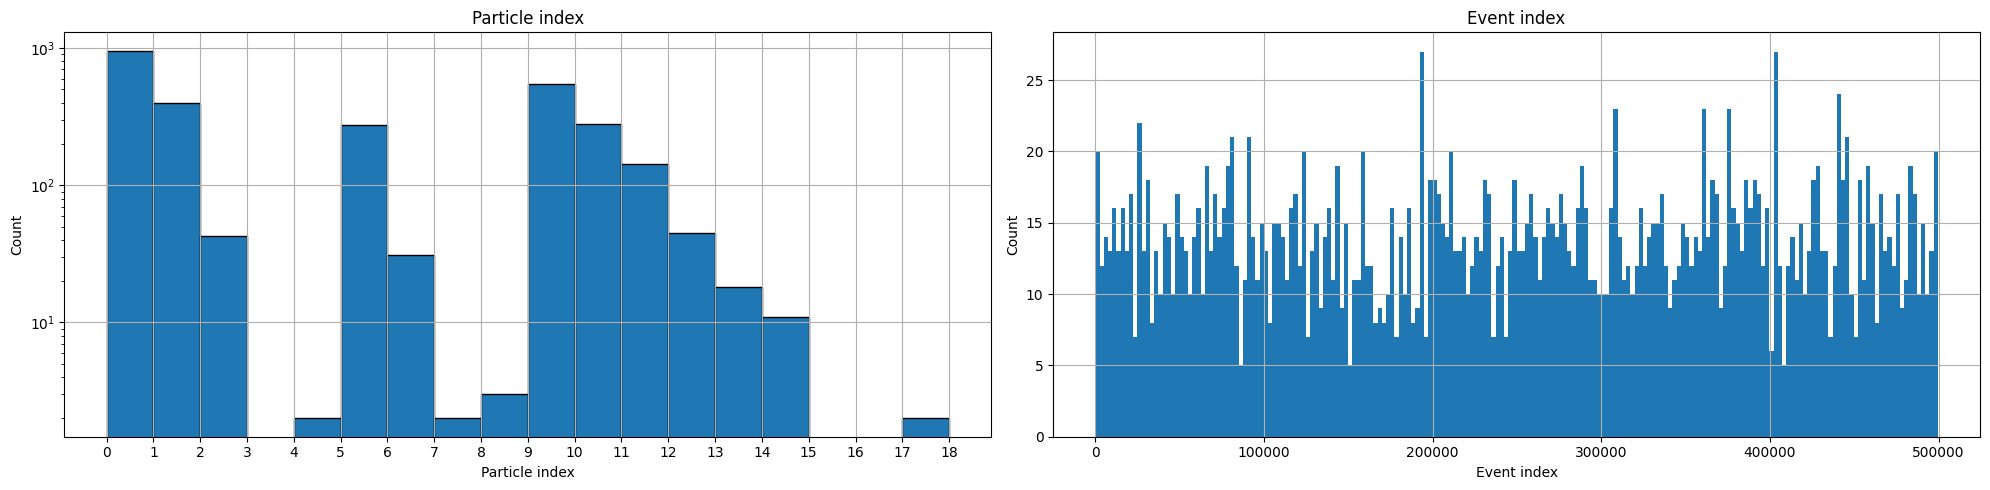

In [ ]:
zero_idex_particle, zero_idnex_event = split_particle_event(zero_phi_index)
event_particle_hist(zero_idnex_event, zero_idex_particle)

In [ ]:
import numpy as np

val, counts = np.unique(zero_idnex_event, return_counts=True)
print(f"Number of events with at least a 0 line: {len(counts)}")

Number of events with at least a 0 line: 2750


numbero of W events: 2318
numbero of Z events: 0
numbero of WW events: 394
numbero of ZZ events: 0
numbero of WWW events: 30
numbero of ZZZ events: 0
numbero of WWWW events: 6
numbero of ZZZZ events: 0
numbero of jet1 events: 756
numbero of jet2 events: 644
numbero of jet3 events: 421
numbero of jet4 events: 187
numbero of jet5 events: 96
numbero of jet6 events: 31
numbero of jet7 events: 14
numbero of jet8 events: 0
numbero of jet9 events: 1


Sum of Z events: 0
Sum of WW events: 2748
Number of MET events: 2750


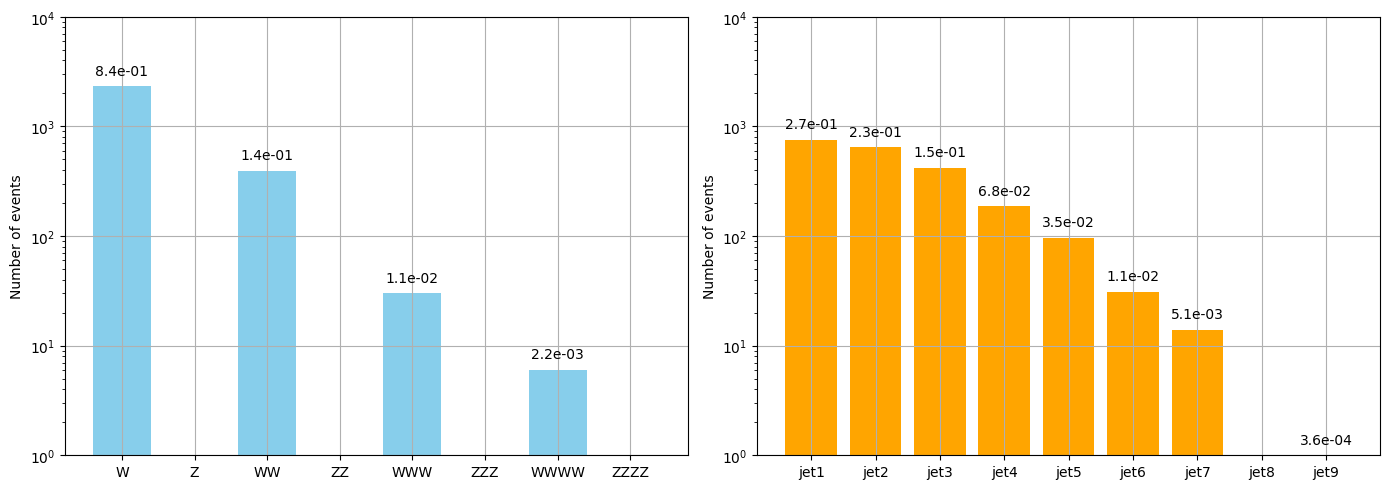

In [ ]:
prod_events_analysis(val)

Tutti gli eventi hanno energia mancante

### $\eta$


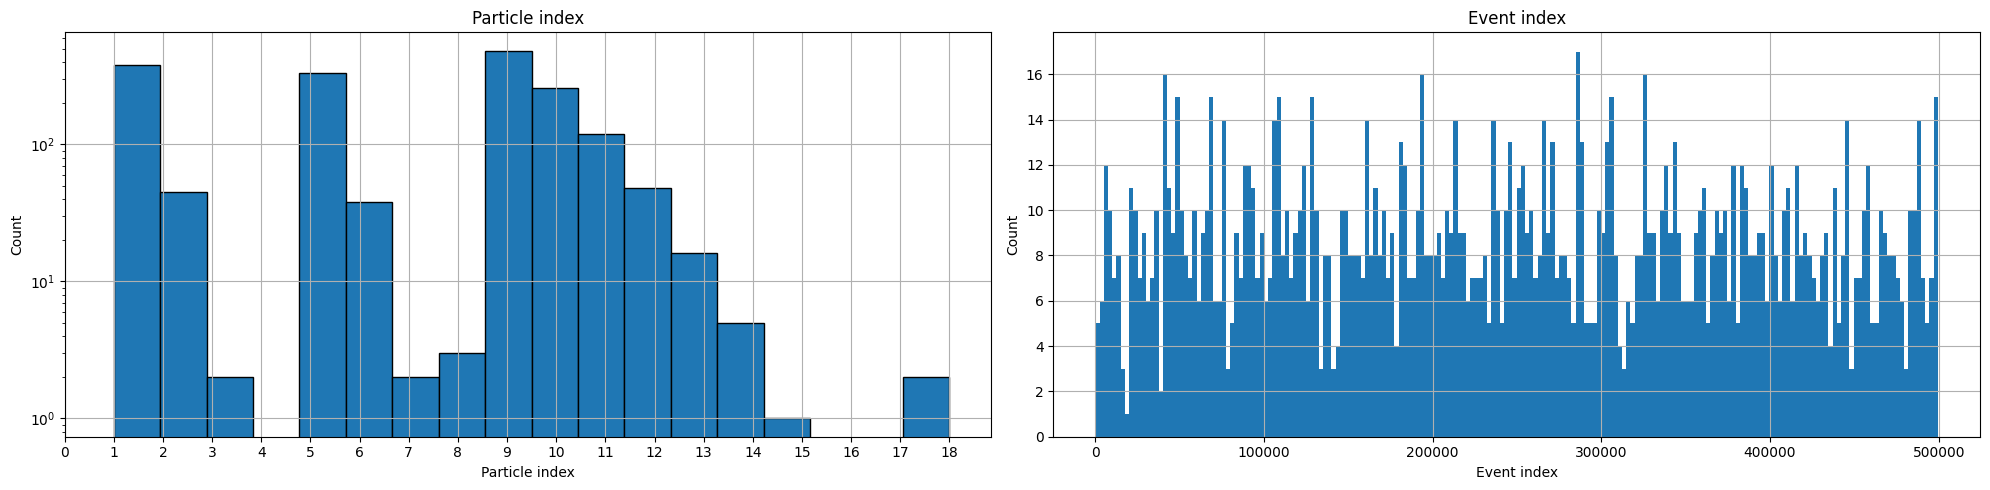

In [ ]:
zero_idex_particle, zero_idnex_event = split_particle_event(zero_eta_index)
event_particle_hist(zero_idnex_event, zero_idex_particle)

In [ ]:
import numpy as np

val, counts = np.unique(zero_idnex_event, return_counts=True)
print(f"Number of events with at least a 0 line: {len(counts)}")

Number of events with at least a 0 line: 1712


numbero of W events: 1295
numbero of Z events: 0
numbero of WW events: 376
numbero of ZZ events: 0
numbero of WWW events: 33
numbero of ZZZ events: 0
numbero of WWWW events: 7
numbero of ZZZZ events: 0
numbero of jet1 events: 384
numbero of jet2 events: 521
numbero of jet3 events: 317
numbero of jet4 events: 161
numbero of jet5 events: 92
numbero of jet6 events: 33
numbero of jet7 events: 10
numbero of jet8 events: 4
numbero of jet9 events: 1


Sum of Z events: 0
Sum of WW events: 1711
Number of MET events: 1712


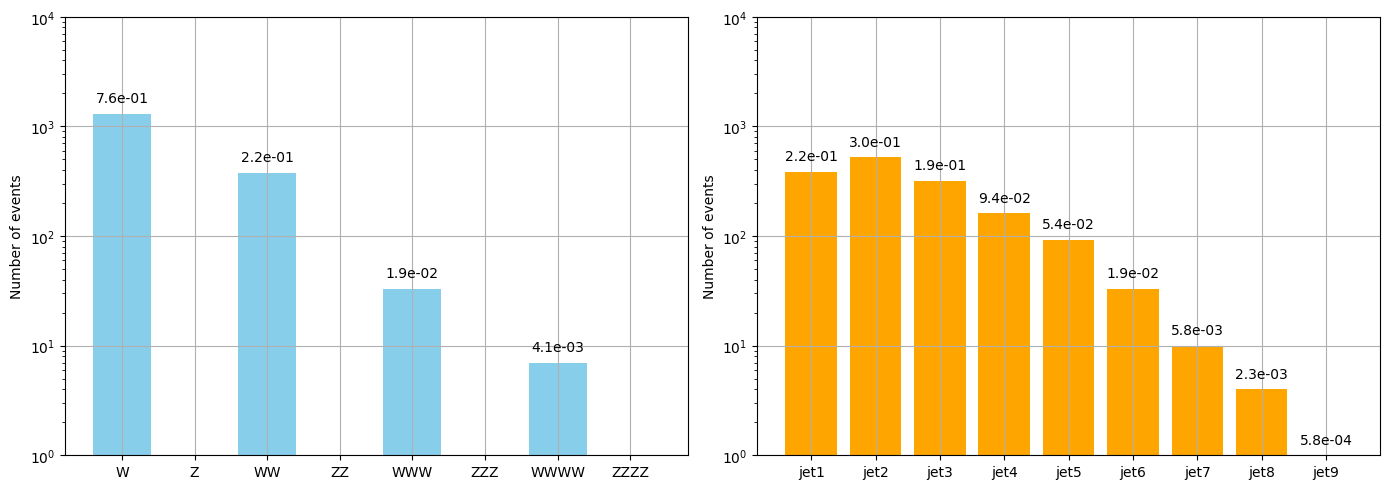

In [ ]:
prod_events_analysis(val)

# Simulated data BSM

## $h^0\rightarrow\tau\tau\,$ dataset analysis


21603/21603 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step


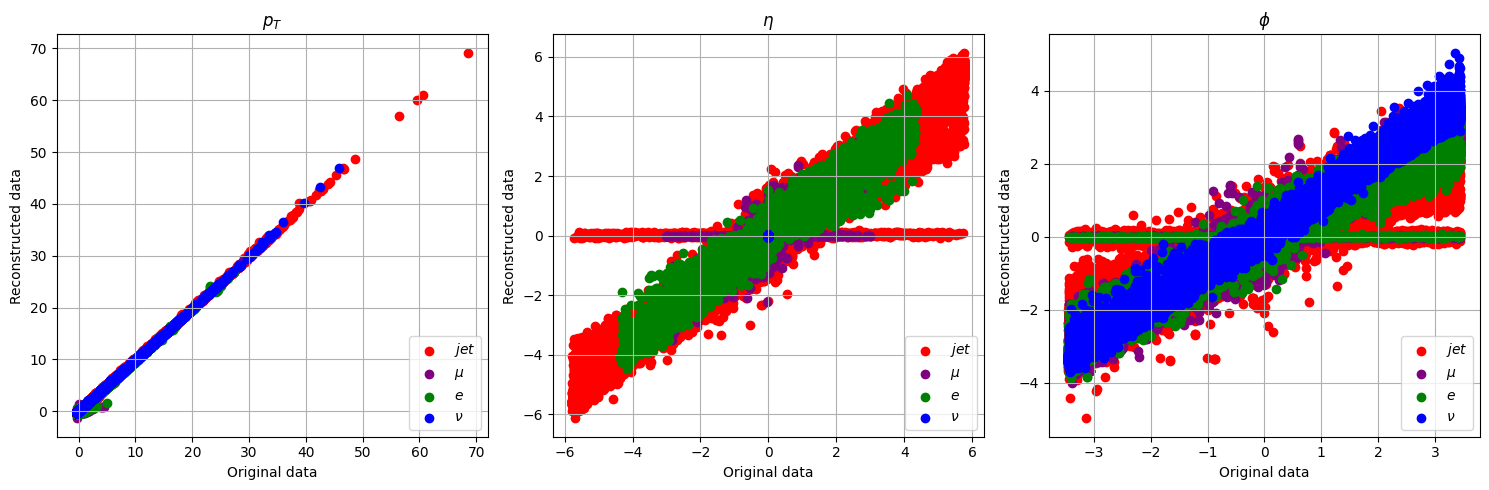

In [ ]:
with h5py.File("gdrive/My Drive/FDL project/dataset/hToTauTau_13TeV_PU20_filtered.h5", 'r') as file:
    h_tt_po = file['Particles'][:]

h_tt = scaler(h_tt_po)

h_tt_rec = net.predict(h_tt)
visualize_results(h_tt, h_tt_rec)
file.close()

## $h^+\rightarrow\tau\nu\,$ dataset analysis


23759/23759 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step


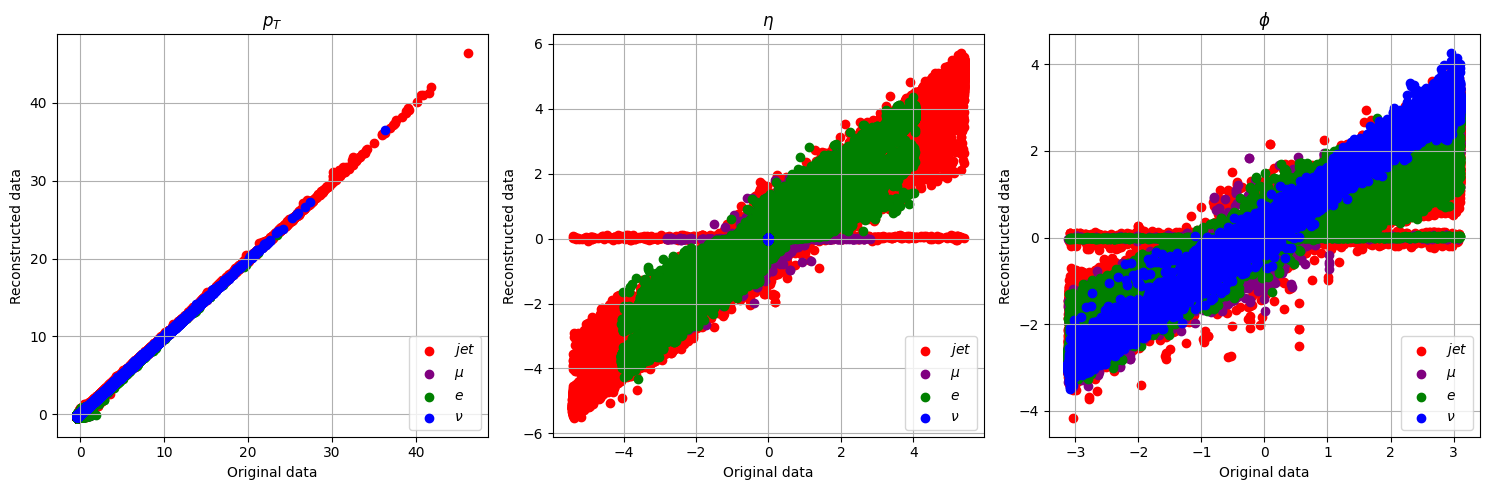

In [ ]:
with h5py.File("gdrive/My Drive/FDL project/dataset/hChToTauNu_13TeV_PU20_filtered.h5", 'r') as file:
    h_tnu_po = file['Particles'][:]

h_tnu = scaler(h_tnu_po)

h_tnu_rec = net.predict(h_tnu)
visualize_results(h_tnu, h_tnu_rec)
file.close()

## $A\rightarrow 4l\,$ dataset analysis


1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


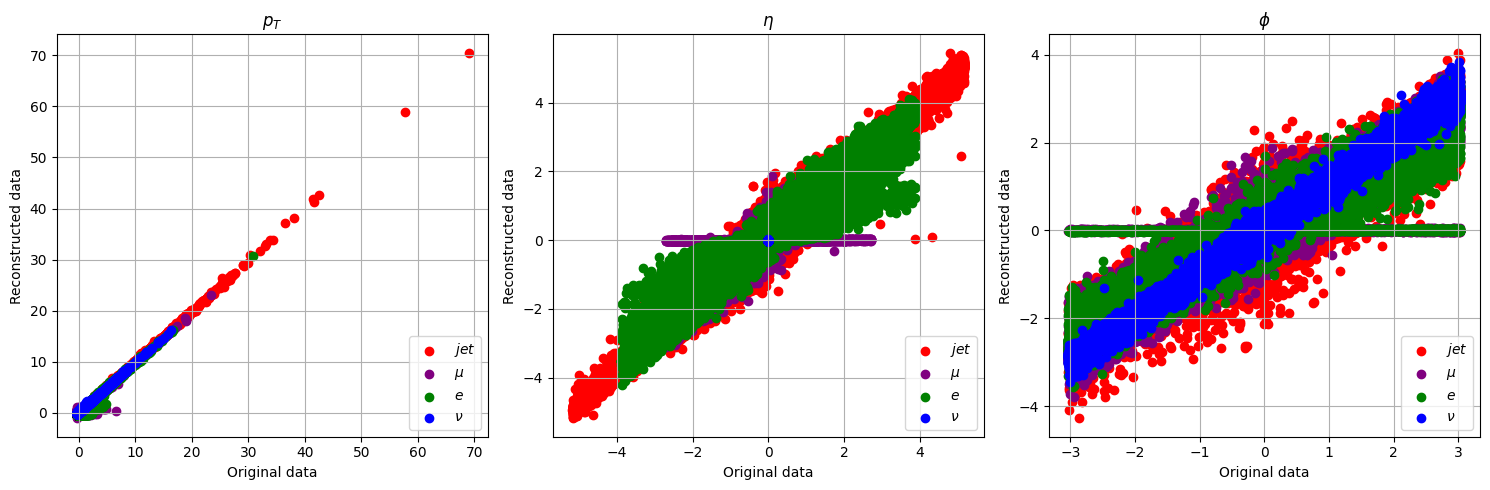

In [ ]:
with h5py.File("gdrive/My Drive/FDL project/dataset/Ato4l_lepFilter_13TeV_filtered.h5", 'r') as file:
    A_4l_po = file['Particles'][:]

A_4l = scaler(A_4l_po)

A_4l_rec = net.predict(A_4l)
visualize_results(A_4l, A_4l_rec)
file.close()

## $LQ\rightarrow b\tau\,$ dataset analysis


10642/10642 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step


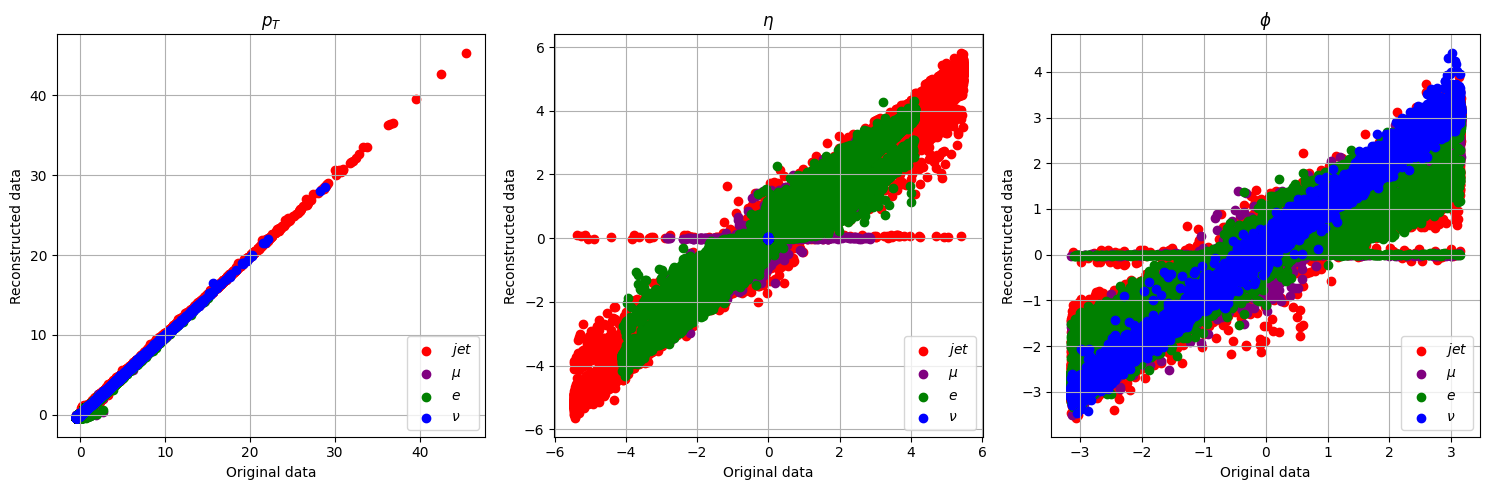

In [ ]:
with h5py.File("gdrive/My Drive/FDL project/dataset/leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5", 'r') as file:
    LQ_bt_po = file['Particles'][:]

LQ_bt = scaler(LQ_bt_po)

LQ_bt_rec = net.predict(LQ_bt)
visualize_results(LQ_bt, LQ_bt_rec)
file.close()

## Recap

In [ ]:
_, _, _, _, loss_h_tt = loss_eventXevent(h_tt, h_tt_rec[:, :, :, 0], zero_pt=-3.91916608e-01, zero_eta=8.42306028e-04, zero_phi=2.08138452e-04)
_, _, _, _, loss_h_tnu = loss_eventXevent(h_tnu, h_tnu_rec[:, :, :, 0], zero_pt=-4.25901880e-01, zero_eta=-4.01769465e-04, zero_phi=-3.43055755e-04)
_, _, _, _, loss_A_4l = loss_eventXevent(A_4l, A_4l_rec[:, :, :, 0], zero_pt=-4.28734457e-01, zero_eta=-1.03627494e-03, zero_phi=3.69865426e-04)
_, _, _, _, loss_LQ_bt = loss_eventXevent(LQ_bt, LQ_bt_rec[:, :, :, 0], zero_pt=-4.71797178e-01, zero_eta=9.31079858e-04, zero_phi=2.75312937e-04)

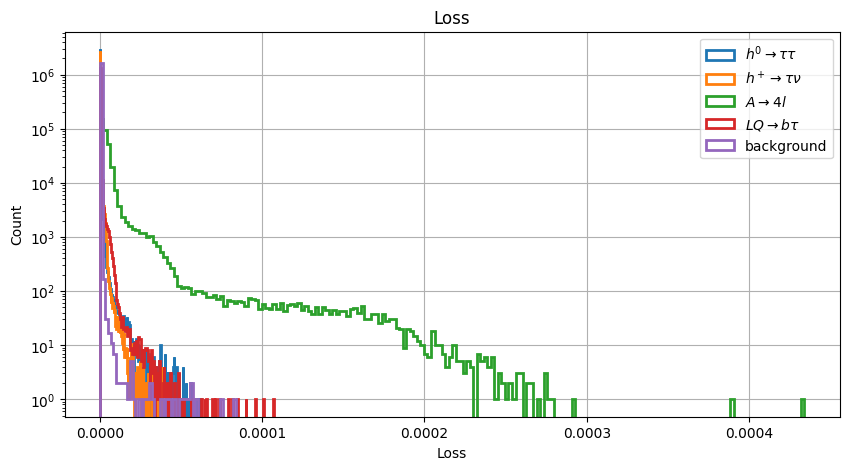

In [ ]:
loss_eventXevent_comparison(loss, [loss_h_tt, loss_h_tnu, loss_A_4l, loss_LQ_bt],
  [r"$h^0\rightarrow\tau\tau$", r"$h^+\rightarrow\tau\nu$", r"$A\rightarrow 4l$", r"$LQ\rightarrow b\tau$"])

## ROC curves

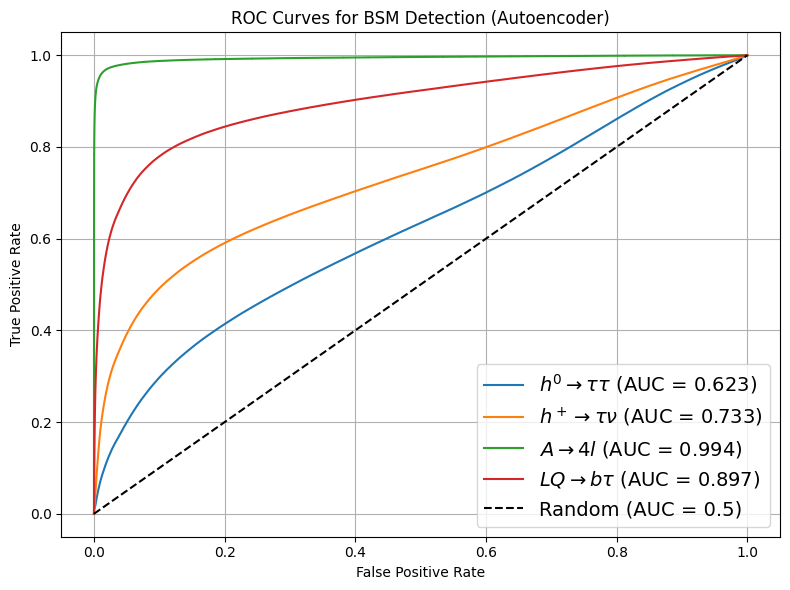

In [ ]:
ROC_curves(loss, [loss_h_tt, loss_h_tnu, loss_A_4l, loss_LQ_bt],
  [r"$h^0\rightarrow\tau\tau$", r"$h^+\rightarrow\tau\nu$", r"$A\rightarrow 4l$", r"$LQ\rightarrow b\tau$"])